In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import chisquare
import math

Gets data from respective csv files, removes any "Statewide Unallocated" data from county name from all files.

In [55]:
cases = pd.read_csv("../../../../data/stage_1/covid_confirmed_usafacts.csv")
deaths = pd.read_csv("../../../../data/stage_1/covid_deaths_usafacts.csv")
pop = pd.read_csv("../../../../data/stage_1/covid_county_population_usafacts.csv")

cases = cases[cases['County Name'] != 'Statewide Unallocated']
deaths = deaths[deaths['County Name'] != 'Statewide Unallocated']

pop = pop[pop['County Name'] != 'Statewide Unallocated']
pop = pop.drop(columns = ['County Name'])

Merges data from all files and makes the dates into a column that will later be used to group the covid cases and deaths.

In [56]:
deathsandpop = pd.merge(deaths, pop, on = ['countyFIPS', 'State'])
deathsandpop2 = pd.melt(deathsandpop, id_vars=['countyFIPS','State','County Name','StateFIPS','population'],var_name='Date', value_name='Deaths')
cases_long = pd.melt(cases, id_vars=['countyFIPS','State','County Name','StateFIPS'], var_name='Date', value_name='Cases')
alldata = pd.merge(deathsandpop2,cases_long, on=['countyFIPS','State','County Name','StateFIPS', 'Date'])

Removes date column to change it into a date_Time type. Values are then sorted by date and county FIP.

In [57]:
separateddatecol = pd.DataFrame(pd.to_datetime(alldata['Date']))
alldatanodate = pd.DataFrame(alldata.drop(columns = ['Date']))
updated = pd.concat([separateddatecol.reset_index(drop=True),alldatanodate.reset_index(drop=True)], axis = 1). fillna(0)
updated = updated.sort_values(by=['countyFIPS', 'Date'])

Adds columns to updated data that have the new cases and deaths per day

In [58]:
updated['New_Cases'] = updated.Cases.diff().fillna(0)
updated['New_Deaths'] = updated.Deaths.diff().fillna(0)
updated['New_Cases']  = np.where(updated['New_Cases']  < 0, 0, updated['New_Cases'])
updated['New_Deaths'] = np.where(updated['New_Deaths'] < 0, 0, updated['New_Deaths'])

Starts data at date of first infection for NY and makes it into a dataframe. Then makes a column for days since the first infection and inserts it into the nydata dataframe.

In [59]:
startDate = pd.Timestamp('2020-03-12')
updatedCovStart = updated[updated['Date'] >= startDate]
nydata = updatedCovStart.loc[updatedCovStart['State']=='NY']

daysSince = pd.DataFrame()
daysSince['Days_Since'] = (nydata['Date']- startDate).dt.days

In [60]:
nydata.insert(10, 'Days_Since', daysSince)

Normalizes the cases and deaths of NY

In [61]:
nydataNorm = nydata
Norm_New_Cases = (nydata['New_Cases'] / nydata['population'])* 10000
Norm_New_Deaths = (nydata['New_Deaths'] / nydata['population'])* 10000
Norm_Cases = (nydata['Cases'] / nydata['population'])* 10000
Norm_Deaths = (nydata['Deaths'] / nydata['population'])* 10000

In [62]:
nydataNorm.insert(10, 'Norm_New_Cases',Norm_New_Cases)
nydataNorm.insert(10, 'Norm_New_Deaths',Norm_New_Deaths)
nydataNorm.insert(10, 'Norm_Cases',Norm_Cases)
nydataNorm.insert(10, 'Norm_Deaths',Norm_Deaths)

Group and sum all of the state of NY's data to get statewide cases and deaths per day.

In [63]:
wholestatenydata = nydata.groupby(['Days_Since','Date']).sum().reset_index(drop=False)

### Calculate RMSEs for new cases and deaths of New York

Linear Regression comparisons for New Cases

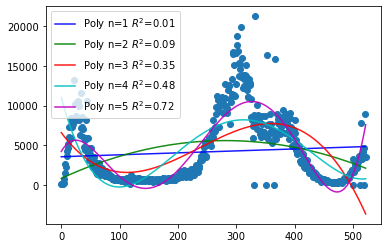

In [64]:
x = pd.DataFrame({'Days_Since': np.linspace(wholestatenydata.Days_Since.min(), wholestatenydata.Days_Since.max(), 523)})

plt.scatter(wholestatenydata.Days_Since, wholestatenydata.New_Cases)

poly_1 = smf.ols(formula='New_Cases ~ Days_Since', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

poly_2 = smf.ols(formula='New_Cases ~ Days_Since + I(Days_Since ** 2.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, alpha=0.9)

poly_3 = smf.ols(formula='New_Cases ~ Days_Since + I(Days_Since ** 2.0) + I(Days_Since ** 3.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly_3.predict(x), 'r-',  alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

poly_4 = smf.ols(formula='New_Cases ~ Days_Since + I(Days_Since ** 2.0) + I(Days_Since ** 3.0) + I(Days_Since ** 4.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly_4.predict(x), 'c-',  alpha=0.9, label='Poly n=4 $R^2$=%.2f' % poly_4.rsquared)

poly_5 = smf.ols(formula='New_Cases ~ Days_Since + I(Days_Since ** 2.0) + I(Days_Since ** 3.0) + I(Days_Since ** 4.0) + I(Days_Since ** 5.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly_5.predict(x), 'm-',  alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)

plt.legend()
plt.show("png")

RMSE for New Cases

In [65]:
casesrms1 = mean_squared_error(x.Days_Since, poly_1.predict(x), squared=False)
casesrms2 = mean_squared_error(x.Days_Since, poly_2.predict(x), squared=False)
casesrms3 = mean_squared_error(x.Days_Since, poly_3.predict(x), squared=False)
casesrms4 = mean_squared_error(x.Days_Since, poly_4.predict(x), squared=False)
casesrms5 = mean_squared_error(x.Days_Since, poly_5.predict(x), squared=False)

print(casesrms1)
print(casesrms2)
print(casesrms3)
print(casesrms4)
print(casesrms5)

3937.629514940279
4124.29386693649
4677.282023276663
4913.908317434294
5348.601654319904


Linear Regression comparisons for New Deaths

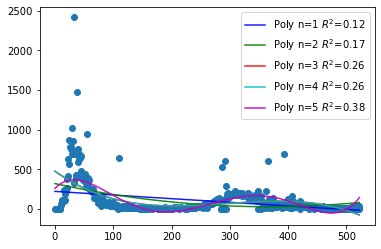

In [66]:
plt.scatter(wholestatenydata.Days_Since, wholestatenydata.New_Deaths)

poly2_1 = smf.ols(formula='New_Deaths ~ Days_Since', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly2_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly2_1.rsquared, alpha=0.9)

poly2_2 = smf.ols(formula='New_Deaths ~ Days_Since + I(Days_Since ** 2.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly2_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly2_2.rsquared, alpha=0.9)

poly2_3 = smf.ols(formula='New_Deaths ~ Days_Since + I(Days_Since ** 2.0) + I(Days_Since ** 3.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly2_3.predict(x), 'r-',  alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly2_3.rsquared)

poly2_4 = smf.ols(formula='New_Deaths ~ Days_Since + I(Days_Since ** 2.0) + I(Days_Since ** 3.0) + I(Days_Since ** 4.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly2_4.predict(x), 'c-',  alpha=0.9, label='Poly n=4 $R^2$=%.2f' % poly2_4.rsquared)

poly2_5 = smf.ols(formula='New_Deaths ~ Days_Since + I(Days_Since ** 2.0) + I(Days_Since ** 3.0) + I(Days_Since ** 4.0) + I(Days_Since ** 5.0)', data=wholestatenydata).fit()
plt.plot(x.Days_Since, poly2_5.predict(x), 'm-',  alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly2_5.rsquared)

plt.legend()
plt.show("png")

RMSE for New Deaths using best fitting regression line.

In [67]:
casesrms1 = mean_squared_error(x.Days_Since, poly2_1.predict(x), squared=False)
casesrms2 = mean_squared_error(x.Days_Since, poly2_2.predict(x), squared=False)
casesrms3 = mean_squared_error(x.Days_Since, poly2_3.predict(x), squared=False)
casesrms4 = mean_squared_error(x.Days_Since, poly2_4.predict(x), squared=False)
casesrms5 = mean_squared_error(x.Days_Since, poly2_5.predict(x), squared=False)

print(casesrms1)
print(casesrms2)
print(casesrms3)
print(casesrms4)
print(casesrms5)

271.1194263212651
274.7144616492527
281.12815572120087
281.1282833113781
289.0989762166481


### Model for top 5 counties with cases within a state and describe their trends.

Top 5 Infected Counties

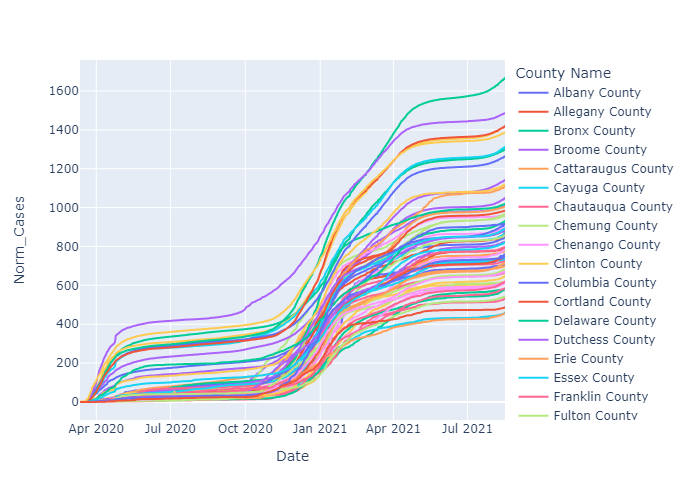

In [68]:
nynormweekly = nydataNorm.groupby(['County Name','Date']).sum().reset_index(drop=False)
nyplot = px.line(nynormweekly, x ='Date', y='Norm_Cases', color='County Name')
nyplot.show("png")

The top five infected counties are somewhat difficult to see since they overlap in the trendline. Below it is shown which counties are in the top five.

In [69]:
topFivecounties = nynormweekly.groupby(nynormweekly['County Name'])[['Norm_Cases']].sum()
topFivecounties = topFivecounties.nlargest(5,['Norm_Cases'])
topFivecounties

,Norm_Cases
County Name,
Rockland County,428463.576118
Richmond County,406749.589934
Westchester County,384663.878053
Nassau County,369418.103004
Suffolk County,363353.302619


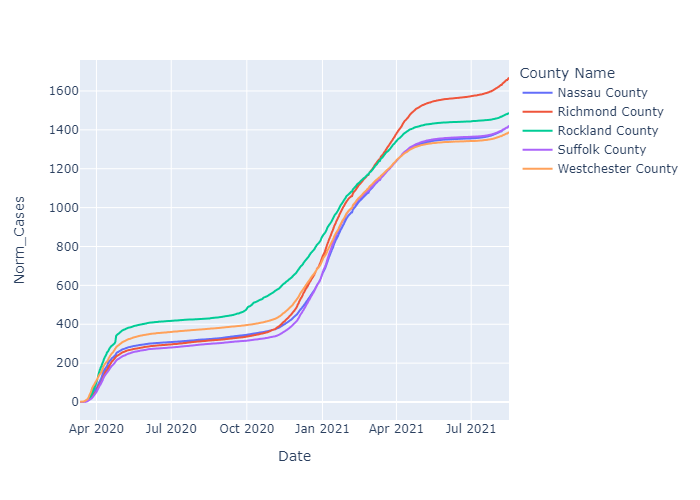

In [70]:
counties = nydata.loc[nydata['County Name'].str.contains(pat = 'Richmond County') | 
                      nydata['County Name'].str.contains(pat = 'Suffolk County')|
                      nydata['County Name'].str.contains(pat = 'Nassau County') |
                      nydata['County Name'].str.contains(pat = 'Rockland County')|
                      nydata['County Name'].str.contains(pat = 'Westchester County')
                     ]
countyplot = px.line(counties, x ='Date', y='Norm_Cases', color='County Name')
countyplot.show("png")

The trendlines for the counties are very similar. They all have a somewhat sharp rise in apr 2020 that stays constant from between then and july up until october. A while after october, the cases in each county have a sharp rise again until apr 2021 where it again becomes constant until a slight increase after july of 2021. For most of the graph, Rockland county has the highest amount of cases up until the time between jan and apr 2021, where it is overtaken by Richmond county. Nassau and Suffolk have almost the same number of cases for most of the graph after oct 2020 and jan 2021. Before this, Nassau continually had slightly more cases than suffolk. In the begininning of the graph Westchest had the second most cases up until every counties cases started rising between oct 2020 and jan 2021, where it then ties for third with nassau and Suffolk before becoming the lowest of the top 5 counties after apr 2021.

Separting county data into separate dataframes

In [71]:
Richmond = nydata.loc[nydata['County Name'].str.contains(pat = 'Richmond County')]
Suffolk = nydata.loc[nydata['County Name'].str.contains(pat = 'Suffolk County')]
Nassau = nydata.loc[nydata['County Name'].str.contains(pat = 'Nassau County')]
Rockland = nydata.loc[nydata['County Name'].str.contains(pat = 'Rockland County')]
Westchester = nydata.loc[nydata['County Name'].str.contains(pat = 'Westchester County')]

#### Regression lines for each of the top 5 counties

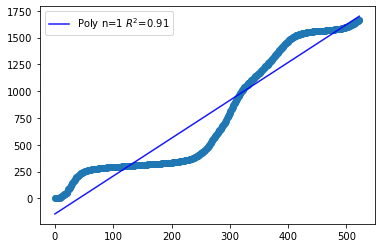

In [72]:
x = pd.DataFrame({'Days_Since': np.linspace(Richmond.Days_Since.min(), Richmond.Days_Since.max(), 523)})

plt.scatter(Richmond.Days_Since, Richmond.Norm_Cases)

Richmondpoly_1 = smf.ols(formula='Norm_Cases ~ Days_Since', data=Richmond).fit()
plt.plot(x.Days_Since, Richmondpoly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % Richmondpoly_1.rsquared, alpha=0.9)

plt.legend()
plt.show("png")

In [73]:
Richmondpoly_1.conf_int()

,0,1
Intercept,-172.738066,-115.809595
Days_Since,3.438156,3.626960


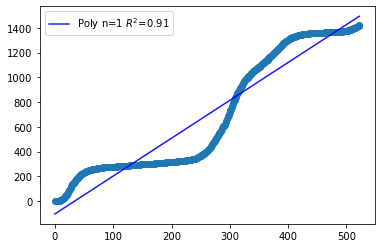

In [74]:
x = pd.DataFrame({'Days_Since': np.linspace(Suffolk.Days_Since.min(), Suffolk.Days_Since.max(), 523)})

plt.scatter(Suffolk.Days_Since, Suffolk.Norm_Cases)

Suffolkpoly_1 = smf.ols(formula='Norm_Cases ~ Days_Since', data=Suffolk).fit()
plt.plot(x.Days_Since, Suffolkpoly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % Suffolkpoly_1.rsquared, alpha=0.9)

plt.legend()
plt.show("png")

In [75]:
Suffolkpoly_1.conf_int()

,0,1
Intercept,-129.664605,-78.287849
Days_Since,2.975051,3.145443


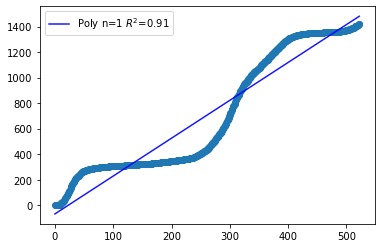

In [76]:
x = pd.DataFrame({'Days_Since': np.linspace(Nassau.Days_Since.min(), Nassau.Days_Since.max(), 523)})

plt.scatter(Nassau.Days_Since, Nassau.Norm_Cases)

Nassaupoly_1 = smf.ols(formula='Norm_Cases ~ Days_Since', data=Nassau).fit()
plt.plot(x.Days_Since, Nassaupoly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % Nassaupoly_1.rsquared, alpha=0.9)

plt.legend()
plt.show("png")

In [77]:
Nassaupoly_1.conf_int()

,0,1
Intercept,-92.668067,-43.637600
Days_Since,2.886117,3.048727


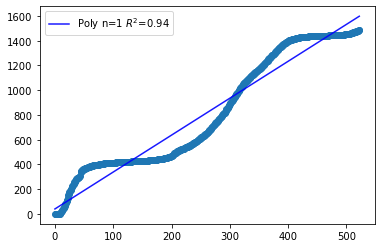

In [78]:
rockx = pd.DataFrame({'Days_Since': np.linspace(Rockland.Days_Since.min(), Rockland.Days_Since.max(), 523)})

plt.scatter(Rockland.Days_Since, Rockland.Norm_Cases)

rockpoly_1 = smf.ols(formula='Norm_Cases ~ Days_Since', data=Rockland).fit()
plt.plot(rockx.Days_Since, rockpoly_1.predict(rockx), 'b-', label='Poly n=1 $R^2$=%.2f' % rockpoly_1.rsquared, alpha=0.9)

plt.legend()
plt.show("png")

In [79]:
rockpoly_1.conf_int()

,0,1
Intercept,20.908018,59.752447
Days_Since,2.919922,3.048750


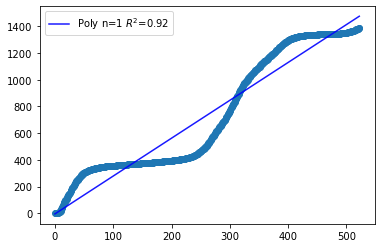

In [80]:
x = pd.DataFrame({'Days_Since': np.linspace(Westchester.Days_Since.min(), Westchester.Days_Since.max(), 523)})

plt.scatter(Westchester.Days_Since, Westchester.Norm_Cases)

Westchesterpoly_1 = smf.ols(formula='Norm_Cases ~ Days_Since', data=Westchester).fit()
plt.plot(x.Days_Since, Westchesterpoly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % Westchesterpoly_1.rsquared, alpha=0.9)

plt.legend()
plt.show("png")

In [81]:
Westchesterpoly_1.conf_int()

,0,1
Intercept,-25.758733,17.659287
Days_Since,2.761506,2.905503


### Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

Read from csv and clean up data

In [119]:
hospdata = pd.read_csv("../../../../data/stage_3/Hospital_Capacity.csv", low_memory=False)
weeklyhospdata = pd.read_csv("../../../../data/stage_3/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv", low_memory=False)

hospdata = hospdata.replace(-999999,0)
weeklyhospdata = weeklyhospdata.replace(-999999,0)
weeklyhospdata = weeklyhospdata.replace('-999,999',0)

hospdata = hospdata.fillna(0)
weeklyhospdata = weeklyhospdata.fillna(0)

Find capcity of hospitals in NY

In [155]:
NYbedCap = hospdata[hospdata['state_abbr']== 'NY']
NYbedCap=NYbedCap['total_staff_ad_icu_beds']

Trendline of NY occupied ICU hospital beds over time. Line for point of no return is plotted as well.

In [165]:
weeklyhospdata['collection_week']=pd.to_datetime(weeklyhospdata['collection_week'])
nyweeklyhospdata = weeklyhospdata[weeklyhospdata['state']=='NY']
ny_weekly_occ= nyweeklyhospdata[['staffed_adult_icu_bed_occupancy_7_day_avg' ,'collection_week']].reset_index(drop=True)
nyweeklyhospdata = nyweeklyhospdata.reset_index(drop=True)
nyweeklyhospdata = nyweeklyhospdata.groupby(['collection_week']).sum().reset_index(drop=False)
ny_weekly_occ['staffed_adult_icu_bed_occupancy_7_day_avg'] = ny_weekly_occ['staffed_adult_icu_bed_occupancy_7_day_avg'].astype(float)
ny_weekly_occ =ny_weekly_occ.groupby(['collection_week']).sum()

In [151]:
noreturnline = nyweeklyhospdata.groupby(['collection_week']).sum().reset_index(drop=False)

point_of_no_return:


4767.0

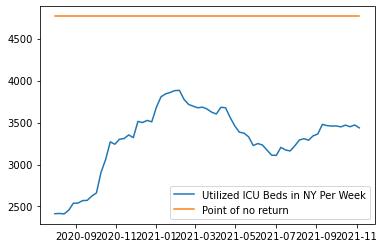

In [154]:
noreturnline['no_return'] = NYbedCap.iloc[0]

fig,ax = plt.subplots()
ax.plot(ny_weekly_occ.index, ny_weekly_occ.staffed_adult_icu_bed_occupancy_7_day_avg.astype(float), label='Utilized ICU Beds in NY Per Week')
ax.plot(noreturnline.collection_week,noreturnline.no_return, label = 'Point of no return')
ax.legend()

print('point_of_no_return:')
NYbedCap.iloc[0]

### Perform hypothesis tests on questions identified in Stage II

Hypothesis for each enrichment variable:
1. Employment rate does not lead to a higher or lower Covid case or death rate.
2. Housing does not lead to higher or lower cases and deaths due to Covid-19.
3. Societal variabes like living with or without a spouse leads to higher or lower Covid-19 cases or deaths.

In [34]:
econ = pd.read_csv("../../../../data/stage_1/econ_data_with_overlays.csv", low_memory=False)
housing = pd.read_csv("../../../../data/stage_1/housing_data_with_overlays.csv", low_memory=False)
social = pd.read_csv("../../../../data/stage_1/social_data_with_overlays.csv", low_memory=False)

econ = econ.rename(columns = econ.iloc[0]).drop([0])
housing = housing.rename(columns = housing.iloc[0]).drop([0])
social = social.rename(columns = social.iloc[0]).drop([0])

Making data more useable

In [35]:
stateNcounty = econ['Geographic Area Name'].apply(lambda x: pd.Series(str(x).split(",")))
stateNcounty[0] = stateNcounty[0].apply(lambda x: pd.Series(str(x).replace("[","")))
stateNcounty[1] = stateNcounty[1].apply(lambda x: pd.Series(str(x).replace("]","")))

econ.insert(1,"State",stateNcounty[1])
econ.insert(1,"County Name",stateNcounty[0])
social.insert(1,"State",stateNcounty[1])
social.insert(1,"County Name",stateNcounty[0])
housing.insert(1,"State",stateNcounty[1])
housing.insert(1,"County Name",stateNcounty[0])

In [36]:
nydata = nydata.drop(columns=['countyFIPS','StateFIPS'])

Separating enrichment data by state and grouping state cases by county

In [37]:
econNY = econ.loc[econ['State'].str.contains(pat ='New York')].reset_index(drop=True)
socialNY = social.loc[social['State'].str.contains(pat ='New York')].reset_index(drop=True)
housingNY = housing.loc[housing['State'].str.contains(pat ='New York')].reset_index(drop=True)

countynydata = nydata.groupby(['County Name']).sum().reset_index(drop=False)

Setting up housing data with covid cases

#### Calculating Chi-Square Stats

#### Housing
H0: There is no relationship between the variables of occupied housing and covid cases/deaths.

HA: There is a relationship between the variables of occupied housing and covid cases/deaths.

In [38]:
housecount = pd.DataFrame(housingNY['County Name'])
group1A = housingNY['Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units'].astype(int)
group2 = countynydata[['County Name','Cases','Deaths']]

In [39]:
housecount.insert(1, 'Cases',group2['Cases'])
housecount.insert(1, 'Deaths',group2['Deaths'])
housecount.insert(1, 'Occ_Housing',group1A)

In [40]:
housecount['row_totals'] = housecount[['Cases', 'Occ_Housing']].sum(axis=1)
Casestotal = housecount['Cases'].sum()
Deathtotal = housecount['Deaths'].sum()
Occ_Housing_tot = housecount['Occ_Housing'].sum()
row_tot_sum = housecount['row_totals'].sum()

expected = pd.DataFrame()
expected['Occ_Housing'] = (housecount['row_totals'] * Occ_Housing_tot) / row_tot_sum
expected['Cases'] = (housecount['row_totals'] * Casestotal) / row_tot_sum
expected['Deaths'] = (housecount['row_totals'] * Deathtotal) / row_tot_sum

observed = pd.DataFrame()
observed['Cases'] = housecount['Cases']
observed['Deaths'] = housecount['Deaths']
observed['Occ_Housing'] = housecount['Occ_Housing']

In [41]:
chi_squared_stat = (((observed - expected)**2) / expected).sum().sum()
print('Chi-squared statistic:')
print(chi_squared_stat)

p_val = 1- stats.chi2.cdf(x = chi_squared_stat, df = 61*2)
print('p-value:')
print(p_val)

crit = stats.chi2.ppf(q = 0.95, df = 61*2)
print('critical value')
print(crit)

Chi-squared statistic:
5449368.5953943515
p-value:
0.0
critical value
148.77926230440488


At the 95% confidence level, the null hypothesis should be rejected as the chi-square statistic is  is greater than the critical value. This means there is significant evidence of a relationship between occupied housing and covid cases/deaths.

#### Employment
H0: There is not a relationship between Employment rate and covid case/death rate.

HA: There is a relationship between Employment rate effects covid case/death rate. 

In [42]:
econcount = pd.DataFrame(econNY['County Name'])
group1B = econNY['Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed'].astype(int)

In [43]:
econcount.insert(1, 'Cases',group2['Cases'])
econcount.insert(1, 'Deaths',group2['Deaths'])
econcount.insert(1, 'Emp_Status', group1B)

In [44]:
econcount['row_totals'] = econcount[['Cases', 'Emp_Status']].sum(axis=1)
Casestotal = econcount['Cases'].sum()
Deathtotal = econcount['Deaths'].sum()
Amt_pop_employed_tot = econcount['Emp_Status'].astype(int).sum()
row_tot_sum = econcount['row_totals'].sum()

expected2 = pd.DataFrame()
expected2['Amt_pop_employed'] = (econcount['row_totals'] * Amt_pop_employed_tot) / row_tot_sum
expected2['Cases'] = (econcount['row_totals'] * Casestotal) / row_tot_sum
expected2['Deaths'] = (econcount['row_totals'] * Deathtotal) / row_tot_sum

observed2 = pd.DataFrame()
observed2['Cases'] = econcount['Cases']
observed2['Deaths'] = econcount['Deaths']
observed2['Amt_pop_employed'] =  econcount['Emp_Status']

In [45]:
chi_squared_stat = (((observed2.astype(float) - expected2)**2) / expected2).sum().sum()
print('Chi-squared statistic: ')
print(chi_squared_stat)

p_val = 1- stats.chi2.cdf(x = chi_squared_stat, df = 61*2)
print('p-value:')
print(p_val)

crit = stats.chi2.ppf(q = 0.95, df = 61*2)
print("Critical value")
print(crit)

Chi-squared statistic: 
5404640.669485509
p-value:
0.0
Critical value
148.77926230440488


At the 95% confidence level, the null hypothesis should be rejected as the chi-square statistic is  is greater than the critical value. This means there is significant evidence of a relationship between employment of people over 16 and in the labor force and covid cases/deaths.

#### Societal Data
H0: Societal variables do not effect covid case/death rate.

HA: Societal variables effects covid case/death rate. 

In [159]:
socialcount = pd.DataFrame(socialNY['County Name'])
group3A = socialNY['Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Married-couple family'].astype(int)
group3B = socialNY['Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present'].astype(int)
group3C = socialNY['Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present'].astype(int)
group2 = countynydata[['County Name','Cases','Deaths']]

socialcount.insert(1, 'Cases',group2['Cases'])
socialcount.insert(1, 'Deaths',group2['Deaths'])
socialcount.insert(1, 'Married_Couples',group3A)
socialcount.insert(1, 'Male_only',group3B)
socialcount.insert(1, 'Female_only',group3C)


socialcount['row_totals'] = socialcount[['Cases', 'Married_Couples']].astype(int).sum(axis=1)
Casestotal = socialcount['Cases'].sum()
Deathtotal = socialcount['Deaths'].sum()
Married_Couples_tot = socialcount['Married_Couples'].sum()
Female_only_tot = socialcount['Female_only'].sum()
Male_only_tot = socialcount['Male_only'].sum()
row_tot_sum = socialcount['row_totals'].sum()

expected3 = pd.DataFrame()
expected3['Married_Couples'] = (socialcount['row_totals'] * Married_Couples_tot) / row_tot_sum
expected3['Male_only'] = (socialcount['row_totals'] * Male_only_tot) / row_tot_sum
expected3['Female_only'] = (socialcount['row_totals'] * Female_only_tot) / row_tot_sum
expected3['Cases'] = (socialcount['row_totals'] * Casestotal) / row_tot_sum
expected3['Deaths'] = (socialcount['row_totals'] * Deathtotal) / row_tot_sum

observed3 = pd.DataFrame()
observed3['Cases'] = socialcount['Cases']
observed3['Deaths'] = socialcount['Deaths']
observed3['Married_Couples'] = socialcount['Married_Couples']
observed3['Male_only'] = socialcount2['Male_only']
observed3['Female_only'] = socialcount3['Female_only']

In [160]:
chi_squared_stat = (((observed3 - expected3)**2) / expected3).sum().sum()
print('Chi-squared statistic: ')
print(chi_squared_stat)

p_val = 1- stats.chi2.cdf(x = chi_squared_stat, df = 61*4)
print('p-value:')
print(p_val)

crit = stats.chi2.ppf(q = 0.95, df = 61*4)
print("Critical value")
print(crit)

Chi-squared statistic: 
5628601.915858532
p-value:
0.0
Critical value
281.437019180335


At the 95% confidence level, the null hypothesis should be rejected as the chi-square statistic is  is greater than the critical value. This means there is significant evidence of a relationship between societal variables (like being a married couple family or not) and covid cases / deaths.